In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = '^IXIC'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_nas.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(13474, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,4.605170,1.0,1.008400,1.008400
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,4.613535,1.0,0.999207,0.999207
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,4.612741,1.0,0.999305,0.999305
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,4.612047,1.0,1.007548,1.007548
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,4.619566,1.0,1.005914,1.005914
1971-02-12,102.050003,102.050003,102.050003,102.050003,102.050003,4.625463,1.0,1.001372,1.001372
1971-02-16,102.190002,102.190002,102.190002,102.190002,102.190002,4.626834,1.0,0.995596,0.995596
1971-02-17,101.739998,101.739998,101.739998,101.739998,101.739998,4.622421,1.0,0.996855,0.996855
1971-02-18,101.419998,101.419998,101.419998,101.419998,101.419998,4.619270,1.0,0.992901,0.992901


In [3]:
df.high[(df.high != df.low)]

Date
1984-10-11      244.699997
1984-10-12      246.199997
1984-10-15      247.699997
1984-10-16      247.899994
1984-10-17      247.100006
                  ...     
2024-07-08    18416.939453
2024-07-09    18511.890625
2024-07-10    18655.189453
2024-07-11    18671.070312
2024-07-12    18556.726562
Name: high, Length: 10015, dtype: float64

In [4]:
SIM_START = pd.to_datetime('1984-10-11')  # first day of legit open/close values
SIM_START

Timestamp('1984-10-11 00:00:00')

In [5]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [6]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [7]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

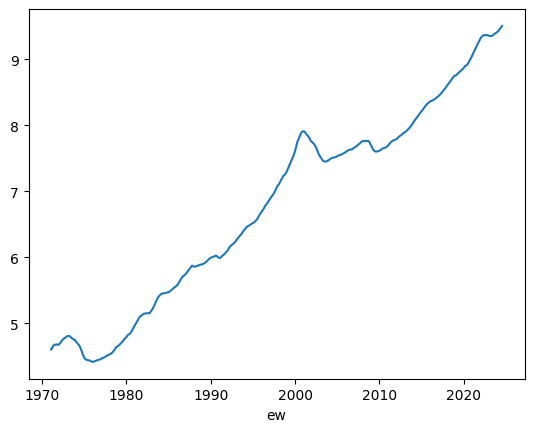

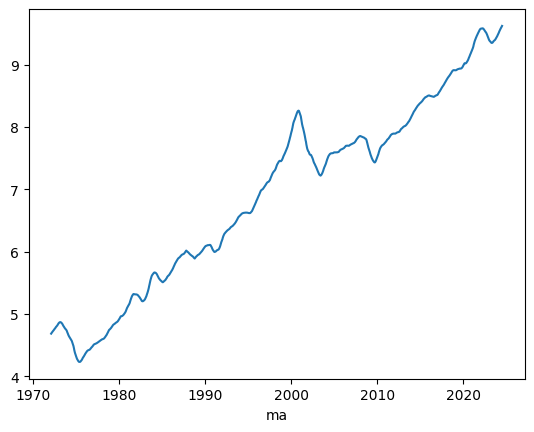

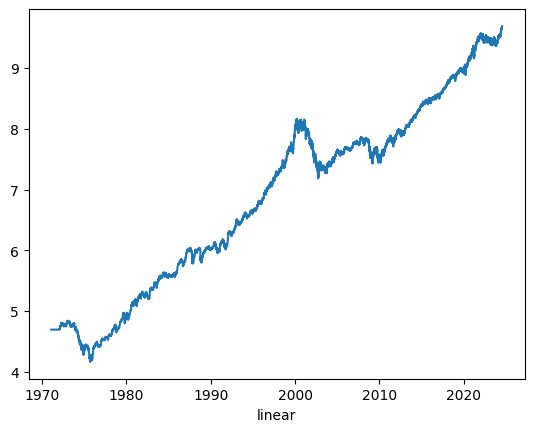

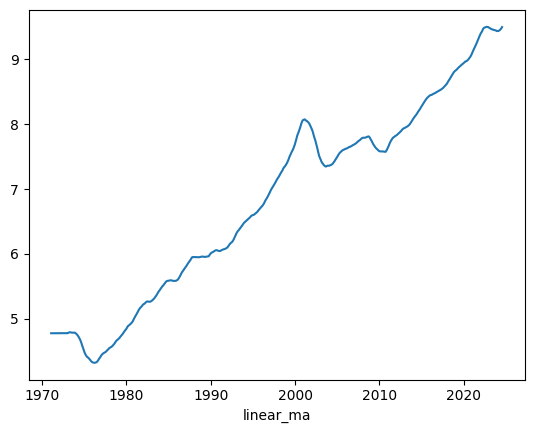

In [8]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [9]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [10]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [11]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [12]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [13]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [14]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(961.6339421108237,
 {'time_param': 235,
  'method': 'ew',
  't': 0.9463760835823656,
  'k': 0.32311302589657903,
  'as_q': False,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 75.18776273786204
Round 1: 975.8872292729495
New best: 975.8872292729495
{'time_param': 235, 'method': 'ew', 't': 0.9463760835823656, 'k': 0.32311302589657903, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


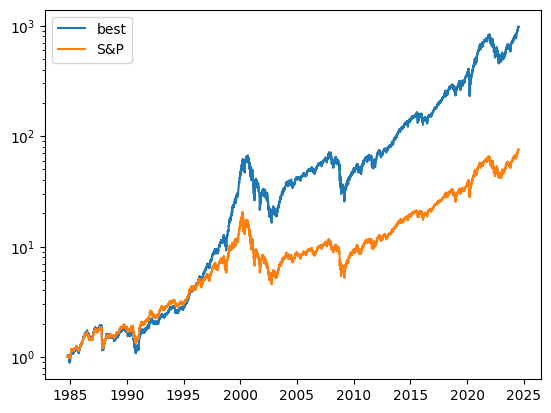

Round 2: 88.38592467756676
Round 3: 1.247583819759309
Round 4: 1.6175373420837953
Round 5: 110.14447717959962
Round 6: 1.004773469497699
Round 7: 1.3703236257721654
Round 8: 918.5590817561563
Round 9: 17.199874932845052
Round 10: 3251.7928719486636
New best: 3251.7928719486636
{'time_param': 239, 'method': 'ma', 't': 0.9548323551703803, 'k': 3.3327945154508223, 'as_q': True, 'transform_f': 'bounded_curve'}


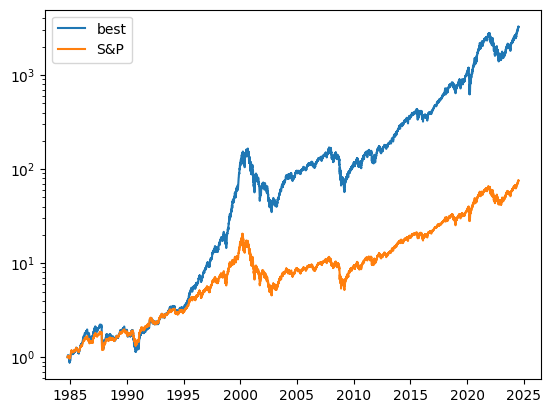

Round 11: 3890.049546786155
New best: 3890.049546786155
{'time_param': 227, 'method': 'ma', 't': 0.9034950868160951, 'k': 5.625608675974697, 'as_q': False, 'transform_f': 'bounded_curve'}


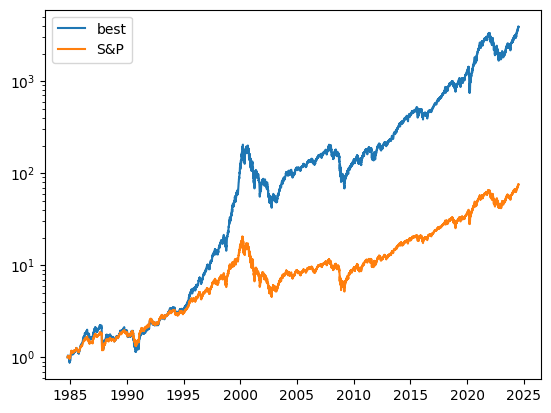

Round 12: 3.3164105032996236
Round 13: 438.90967345120634
Round 14: 1.545715994230238
Round 15: 2.223431297486172
Round 16: 17.187396266519094
Round 17: 173.08832457604353
Round 18: 620.4221537548876
Round 19: 30.460901049880306
Round 20: 2.475391063995066
Round 21: 26.00347168184518
Round 22: 1474.6279150709431
Round 23: 118.20638928337473
Round 24: 121.46574324825718
Round 25: 1.5717169547773508
Round 26: 6.441258954429934
Round 27: 94.94323857968841
Round 28: 3.280239604601129
Round 29: 3.876380707050863
Round 30: 7.075948207385068
Round 31: 3803.541632533185
Round 32: 3013.8031749833845
Round 33: 37.33806779417377
Round 34: 1905.1497583014177
Round 35: 142.1073211221879
Round 36: 8.002831146925878
Round 37: 1.9463915409526842
Round 38: 178.5095819780015
Round 39: 1.7843007532286883
Round 40: 504.1982104551788
Round 41: 4.873920376261167
Round 42: 261.2185005913468
Round 43: 662.9279135457663
Round 44: 1.711514341440835
Round 45: 1.1639135017183802
Round 46: 41.02032185710527
Round 

In [15]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 75.18776273786204
Round 1: 146.7252334213929
Round 2: 437.3424533608878
Round 3: 5.769636568754061
Round 4: 1988.9546015596113
Round 5: 571.0072784317227
Round 6: 831.4676863463285
Round 7: 4017.6768188997
New best: 4017.6768188997
{'time_param': 216, 'method': 'ma', 't': 0.9873850942315245, 'k': 5.908898017878682, 'as_q': False, 'transform_f': 'bounded_curve'}


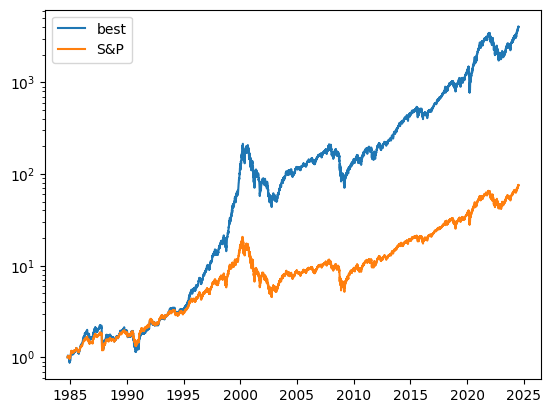

Round 8: 3823.999183065965
Round 9: 2946.6260961585567
Round 10: 157.271463122387
Round 11: 4001.7541352576764
Round 12: 4001.750335837006
Round 13: 3877.1837612015474
Round 14: 2201.29094099708
Round 15: 4001.749761361659
Round 16: 4001.749513908301
Round 17: 4001.7499104580506
Round 18: 1030.5936919819526
Round 19: 4005.9260457099726
Round 20: 4001.750160800524
Round 21: 4001.7502663825226
Round 22: 4001.7505588817494
Round 23: 3895.270585937401
Round 24: 4001.749715002146
Round 25: 4001.749754215794

Factor: 1.03125
Do nothing res: 75.18776273786204
Round 1: 4001.7524772748816
Round 2: 1290.2159340644598
Round 3: 1875.81700147871
Round 4: 2084.2630959369108
Round 5: 4001.7499786446415
Round 6: 4001.75229635645
Round 7: 266.81980270176376
Round 8: 3926.1036252756453
Round 9: 4001.75099510345
Round 10: 4014.2629555095464
Round 11: 4001.7510214501644
Round 12: 3077.909347844994
Round 13: 4001.7507046172846
Round 14: 4001.7510887686894
Round 15: 3014.9933429915027
Round 16: 3875.4372484

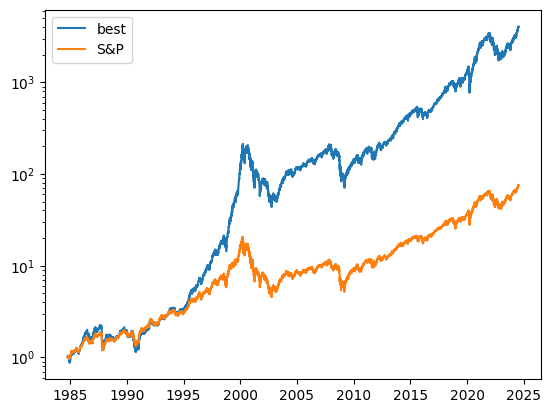

Round 20: 2080.705019731389
Round 21: 4001.7503490197446
Round 22: 4001.7503326353813
Round 23: 4001.750396610821
Round 24: 4001.7510847809076
Round 25: 4001.7527368621368

Factor: 1.015625
Do nothing res: 75.18776273786204
Round 1: 3385.9616880953577
Round 2: 4001.750953477512
Round 3: 578.840583948315
Round 4: 4001.750035656218
Round 5: 3426.0805402331794
Round 6: 3871.7807765672146
Round 7: 1842.3816279115179
Round 8: 4001.7510417555845
Round 9: 314.8135117852861
Round 10: 4001.750096232365
Round 11: 4001.7504899741084
Round 12: 3929.976952923811
Round 13: 3956.5472386762353
Round 14: 4001.750176337066
Round 15: 2059.9169816872813
Round 16: 4001.7511406811514
Round 17: 4001.750216583612
Round 18: 4001.750790609753
Round 19: 291.87010567775496
Round 20: 2627.7102943333593
Round 21: 31.286803352129624
Round 22: 2449.424835661548
Round 23: 3968.3716106449606
Round 24: 3867.816743839657
Round 25: 2605.448772946458

Factor: 1.0078125
Do nothing res: 75.18776273786204
Round 1: 3814.168605

In [16]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [18]:
stop

NameError: name 'stop' is not defined

In [41]:
# Force set:
best_out = 975.8872292729495
params_out = {'time_param': 235, 'method': 'ew', 't': 0.9463760835823656, 'k': 0.32311302589657903, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


In [42]:
final_out = simulate(df, params_out)

In [43]:
amt_in = final_out['amt_in'][-1]
amt_in

0.8247967117482911

In [44]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.6825677682094576

In [45]:
params_out

{'time_param': 235,
 'method': 'ew',
 't': 0.9463760835823656,
 'k': 0.32311302589657903,
 'as_q': False,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


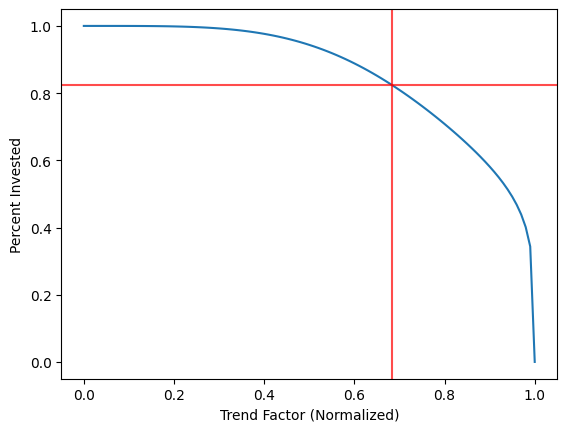

In [46]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

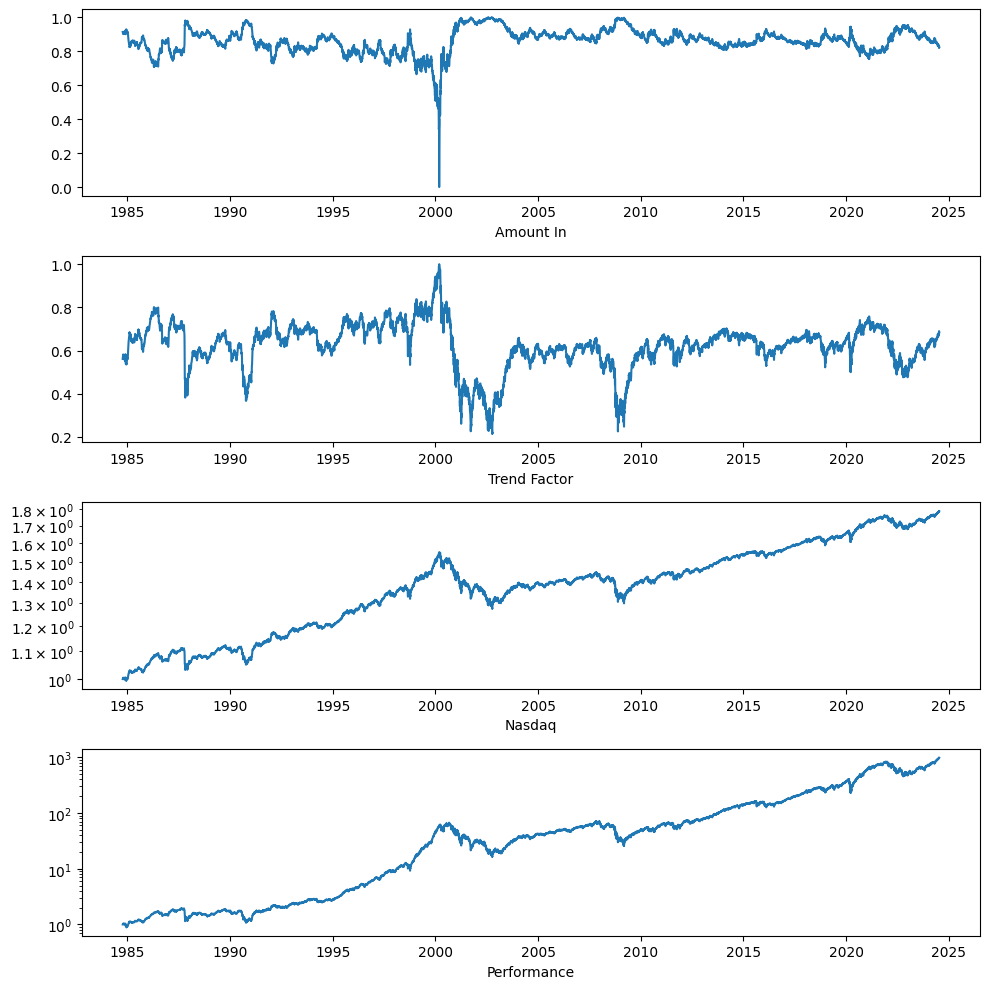

In [47]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('Nasdaq')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [48]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Nasdaq')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

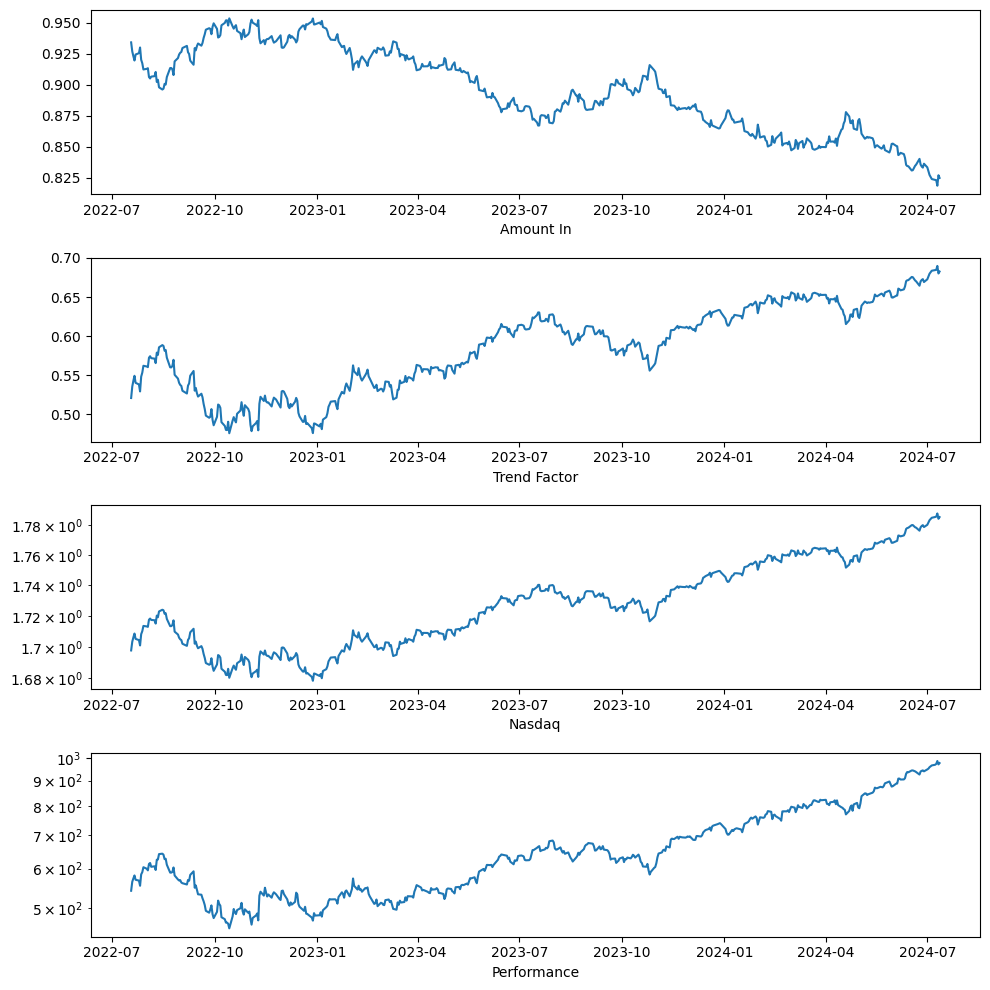

In [49]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('Nasdaq')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [50]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(975.8872292729495,
 {'time_param': 235,
  'method': 'ew',
  't': 0.9463760835823656,
  'k': 0.32311302589657903,
  'as_q': False,
  'transform_f': 'bounded_sigmoid'})

In [51]:
round(final_out['amt_in'][-1], 4)

0.8248